<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/amadeus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
# """ START UP """
# import os
# import shutil
# if os.path.exists('/content/HiloCATsSN1991bg') == True:
#     shutil.rmtree('/content/HiloCATsSN1991bg')
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
# else:
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

# !pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
# !pip install requests
# !pip install sncosmo
# !pip install iminuit

In [350]:
""" IMPORTS """
import os
import time
import glob
import json
import snpy
import shutil
import sncosmo
import requests
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from zipfile import ZipFile
from requests.auth import HTTPBasicAuth
from HiloCATsSN1991bg.scripts import tns_redshifts
from astropy.table import QTable, Table, Column
from astropy import units as u

In [351]:
""" GLOBALS """
# TNS CREDINTIALS
tns_bot_id = '73181'
tns_bot_name = 'YSE_Bot1'
tns_bot_api_key = '0d771345fa6b876a5bb99cd5042ab8b5ae91fc67'

# PATHS
ROOT_PATH = '/content/HiloCATsSN1991bg/'

SNPY_ROOT = ROOT_PATH+'snpy/'
SNPY_BURNS = SNPY_ROOT+'burns/'
SNPY_BURNS_PLOTS = SNPY_BURNS+'plots/'

PLOTS_ROOT = ROOT_PATH+'plots/'

PROB_CHILD_TXT = SNPY_ROOT+'problem_children.txt'
# PROBLEM_CHILDREN = ['1032212120425304400']  # Running list of problematic SNe: '1032212120425304400' - David believes it might be a shock breakout but ATLAS reports it as SN1a
#                                             #


In [352]:
""" GENERAL """
def recover_dir():
    directories = [ROOT_PATH,
                   SNPY_ROOT, SNPY_BURNS, SNPY_BURNS_PLOTS,
                   PLOTS_ROOT]
    for dir in directories:
        if os.path.exists(dir) == False:
            os.mkdir(dir)
    if os.path.exists(PROB_CHILD_TXT) == False:
        with open(PROB_CHILD_TXT, 'w') as f:
            pass
    return

def TNS_details(ra, dec):
    # Code from David
    headers = tns_redshifts.build_tns_header(tns_bot_id, tns_bot_name)
    tns_api_url = f"https://www.wis-tns.org/api/get"

    # get the API URLs
    search_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="search")
    get_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="get")

    search_data = tns_redshifts.build_tns_search_query_data(tns_bot_api_key, ra, dec)
    transients = tns_redshifts.rate_limit_query_tns(search_data, headers, search_tns_url)

    get_data = tns_redshifts.build_tns_get_query_data(tns_bot_api_key, transients[0])
    transient_detail = tns_redshifts.rate_limit_query_tns(get_data, headers, get_tns_url)

    return transient_detail

def snpy_fit(path, objname, skip_problems=False, use_saved=False, snpy_plots=True):
    problem_children = handle_problem_children(state='READ') # Open problem children

    if skip_problems and (objname in problem_children):
        return None
    else:
        try:
            if use_saved and os.path.exists(SNPY_BURNS+objname+'_EBV_model2.snpy'):
                n_s = snpy.get_sn(SNPY_BURNS+objname+'_EBV_model2.snpy')
            else:
                n_s = snpy.get_sn(path)
                n_s.choose_model('EBV_model2', stype='st')
                n_s.set_restbands() # Auto pick appropriate rest-bands
                n_s.fit(bands=None, dokcorr=True, k_stretch=False, reset_kcorrs=True, **{'mangle':1,'calibration':0})
                n_s.save(SNPY_BURNS+objname+'_EBV_model2.snpy')
                if snpy_plots:
                    n_s.plot(outfile=SNPY_BURNS_PLOTS+objname+'_snpyplots.png')
                    plt.show()
        except:
            problem_children = np.append(problem_children, objname)
            handle_problem_children(state='WRITE', problem_c=problem_children) # Commit problem children
            return None

    plt.close()
    return {'mu': n_s.get_distmod(), 'z': n_s.z, 'st': n_s.st, 'Tmax': n_s.Tmax, 'EBVHost': n_s.EBVhost}

def read_DR3(loc='/content/HiloCATsSN1991bg/DR3_fits.dat'):
    data = np.genfromtxt(loc, dtype=str, skip_header=1)
    dr3 = {}
    for n in range(len(data[:, 0])):
        dr3.update({data[:, 0][n]: {'st': float(data[:, 1][n]), 'e_st': float(data[:, 2][n]), 'z': float(data[:, 3][n]),
                           'Tmax': float(data[:, 5][n]), 'e_Tmax': float(data[:, 6][n]),
                           'EBVHost': float(data[:, 25][n]), 'e_EBVHost': float(data[:, 26][n])}})
    return dr3

def dict_unpacker(path, delimiter=', '):
    with open(path, 'r') as f:
        hdr = f.readline()[:-1].split(delimiter)

    data = np.genfromtxt(path, delimiter=delimiter, dtype=str, skip_header=1)
    temp_objs = {}
    for i in range(len(data[:, 0])):
        obj = data[:, 0][i]
        temp_objs.update({obj: {}})
        for j in range(len(hdr)):
            temp_objs[obj].update({hdr[j]: data[i, j]})
    return temp_objs

def dict_packer(data_dict, save_loc, delimiter=', '):
    catagories = list(data_dict[list(data_dict.keys())[0]].keys())
    with open(save_loc, 'w') as f:
        f.write('objname')
        for category in catagories:
            f.write(delimiter+category)
        f.write('\n')
        for objname in data_dict:
            f.write(objname)
            for category in catagories:
                f.write(delimiter+str(data_dict[objname][category]))
            f.write('\n')
    return

def handle_problem_children(state, problem_c=None):
    if state == 'READ':
        # Read problem children
        problem_c = np.genfromtxt(PROB_CHILD_TXT, dtype=str)
        return problem_c
    elif state == 'WRITE':
        # Write problem children
        problem_c = np.unique(problem_c)
        with open(PROB_CHILD_TXT, 'w') as f:
            for c in problem_c:
                f.write(c+'\n')
        return None
    else:
        raise Exception("Invalid state: '"+state+"' [READ/WRITE]")



In [353]:
def burns_cspvdr3():
    print('Fitting CSP data with SNooPy...')
    # Get Chris Burns Data
    objnames = np.genfromtxt('/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt', dtype=str, delimiter=', ')

    # Get CSP paths of Chris Burns Data
    objpaths = []
    for name in objnames:
        if os.path.exists('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt'):
            objpaths.append('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt')
        else:
            print(name, 'not found...')

    objs = {}
    for n in range(len(objpaths)):
        trakcer = '['+str(n+1)+'/'+str(len(objpaths))+']' # Purely cosmetic
        objname = objpaths[n][39:-9]
        temp_dict = snpy_fit(objpaths[n], objname, skip_problems=True, use_saved=True, snpy_plots=False)
        if temp_dict is not None:
            print(trakcer, objname, '\t| mu:', temp_dict['mu'], 'z =', temp_dict['z'], 'st =', temp_dict['st'], 'Tmax =', temp_dict['Tmax'], 'EBVHost =', temp_dict['EBVHost'])
            objs.update({objname: temp_dict})
        else:
            print(trakcer, objname, '\t| problem child, skipping...')

    dict_packer(objs, SNPY_BURNS+'saved.txt', delimiter=', ') # Save data from fitting

def burns_plotting(choice):
    if 'reg_hist' in choice:
        print('Ploting Histogram of SNooPy Fitting Parameters...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)
        reg_params = [st, Tmax, EBVHost]
        bins_reg = [15, 20, 15]
        plot_title = 'SNooPy Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(reg_params[i], bins=bins_reg[i])
            ax[i].set_title(titles[i])
        plt.show()

    if 'res_hist' in choice:
        print('Ploting Histogram of SNooPy-Chris Burns Parameters Residuals...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)

        st_res, Tmax_res, EBVHost_res = [], [], []
        dr3 = read_DR3()
        for n in range(len(objnames)):
            if objnames[n] in dr3:
                st_res.append(st[n] - dr3[objnames[n]]['st'])
                Tmax_res.append(Tmax[n] - dr3[objnames[n]]['Tmax'])
                EBVHost_res.append(EBVHost[n] - dr3[objnames[n]]['EBVHost'])\

        res_params = [st_res, Tmax_res, EBVHost_res]
        bins_res = [30, 50, 20]
        plot_title = 'SNooPy-Chris Burns Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(res_params[i], bins=bins_res[i])
            ax[i].set_title(titles[i])
        plt.show()

    if 'zvmu' in choice:
        print('Ploting redshift [z] vs distance mod [mu] of SNooPy Parameters...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, mu, z = data[:, 0], data[:, 1].astype(float), data[:, 2].astype(float)

        plt.figure(figsize=(8, 4))
        for n in range(len(objnames)):
            plt.loglog(z[n], mu[n], label=objnames[n], marker='o')
        plt.title('CSP Redshift vs. Distance Mod\n SNe # = '+str(len(objnames)))
        plt.xlabel('Redshift')
        plt.ylabel('Distance Mod')
        plt.legend()
        plt.show()

    return

Fitting CSP data with SNooPy...
[1/13] SN2005bl 	| mu: 35.076243726419676 z = 0.0241 st = 0.3979034723372321 Tmax = 483.09002350678566 EBVHost = 0.3234918435872179
[2/13] SN2005ke 	| mu: 31.30608249134693 z = 0.0049 st = 0.4761469215113146 Tmax = 699.5454461280124 EBVHost = 0.25779029179620605
[3/13] SN2006bd 	| problem child, skipping...
[4/13] SN2006gt 	| mu: 36.30503452737874 z = 0.0448 st = 0.577353838544286 Tmax = 1003.946973539827 EBVHost = 0.04259768199813767
[5/13] SN2006mr 	| problem child, skipping...
[6/13] SN2007N 	| mu: 33.78830334230361 z = 0.0129 st = 0.8702553711014981 Tmax = 1105.9138952466076 EBVHost = 0.4838832613605036
[7/13] SN2007al 	| mu: 33.679398021724815 z = 0.0122 st = 0.3583345909407717 Tmax = 1170.4266621277882 EBVHost = 0.12921517161735216
[8/13] SN2007ax 	| problem child, skipping...
[9/13] SN2007ba 	| mu: 36.05405045038354 z = 0.0385 st = 0.5948306952477466 Tmax = 1198.0056747983167 EBVHost = 0.16074375431717605
[10/13] SN2008bd 	| problem child, skippin

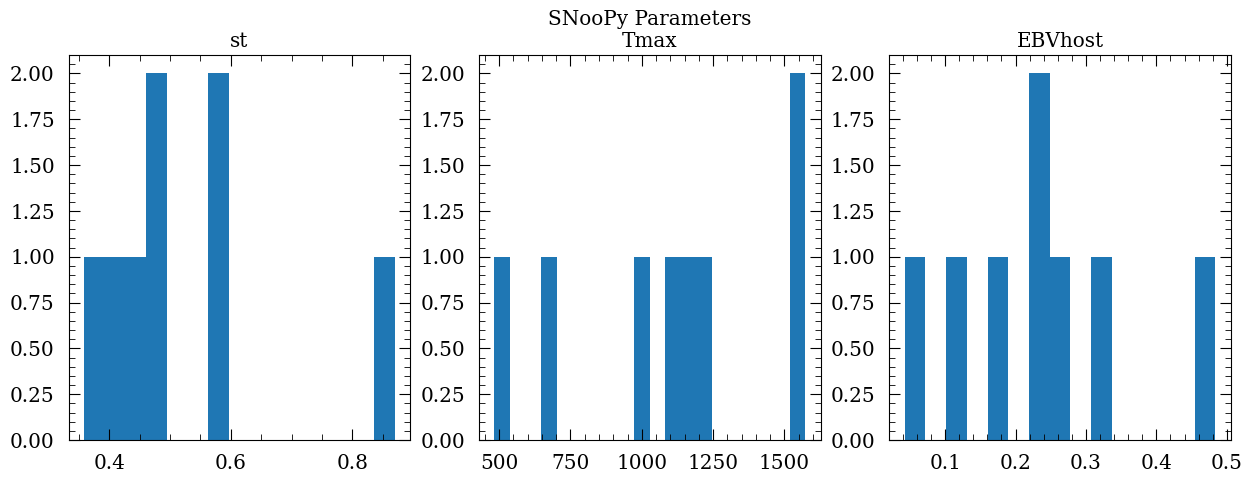

Ploting Histogram of SNooPy-Chris Burns Parameters Residuals...


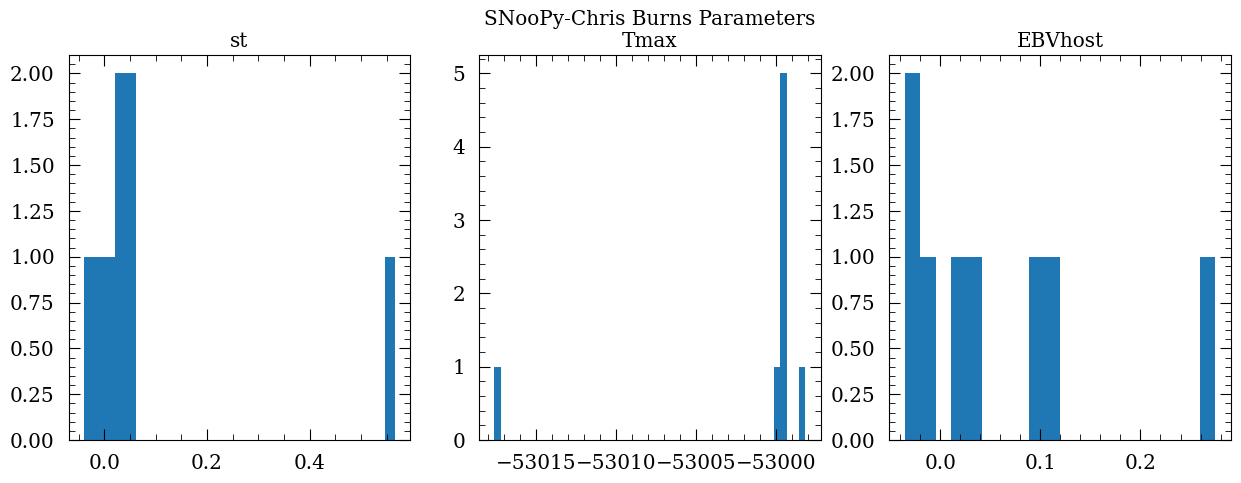

Ploting redshift [z] vs distance mod [mu] of SNooPy Parameters...


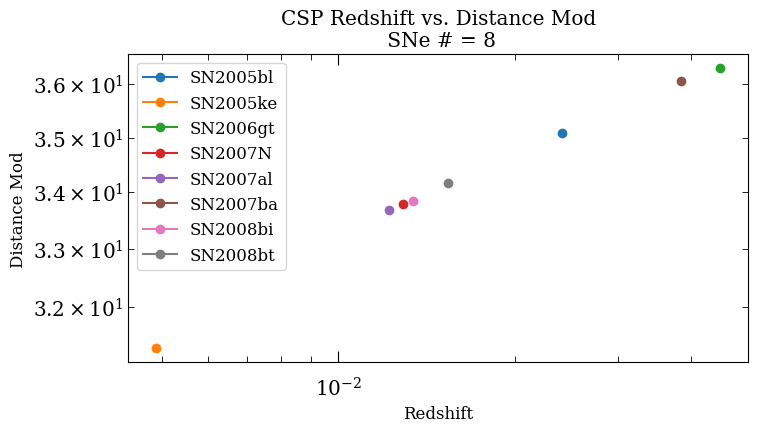

|---------------------------|
 Run-time:  3.1696 seconds
|---------------------------|


In [354]:
""" MAIN """
if __name__ == '__main__':
    start = time.time() # Runtime tracker

    recover_dir() # Recovering vital directories

    burns_cspvdr3()
    burns_plotting(['reg_hist', 'res_hist', 'zvmu']) # Options: ['reg_hist', 'res_hist', 'zvmu']

    print('|---------------------------|\n Run-time: ', round(time.time()-start, 4), 'seconds\n|---------------------------|')